## Giới thiệu
Trong xử lý ảnh, mỗi ảnh có hàng ngàn pixels, mỗi pixel được xem như 1 feature, vậy nếu như một bức ảnh có kích thước 1000 * 1000, thì sẽ có 1.000.000 features. Với normal feed-forward neural networks, mỗi layer là full-connected với previous input layer. Trong normal feed-forward neural network, với mỗi layer, có 1.000.000 pixels, mỗi pixel lại kết nối full-connected với 1.000.000 pixels ở layer trước, tức sẽ có 1012 tham số. Đây là còn số quá lớn để có thể tính được vào thời điểm đó, bởi vì với mô hình có nhiều tham số, sẽ dễ bị overfitted và cần lượng lớn data cho việc training, ngoài ra còn cần nhiều
memory và năng lực tính toán cho việc training và prediction.

Vì vậy, sự ra đời CNN giúp xây dựng các model giải quyết hiệu quả với dữ liệu ảnh. Có 2 đặc tính của image hình thành nên cách hoạt động của CNN trên image, đó là **feature localization** và **feature independence of location**.

* **Feature localization**: mỗi pixel hoặc feature có liên quan với các pixel quanh nó.
* **Feature Independence of location**: mỗi feature dù nó có nằm ở đâu trong bức ảnh, thì nó vẫn mang giá trị của feature đó. CNN xử lý vấn đề có quá nhiều tham số với Shared parameters (feature independence of location) của Locally connected networks (feature loclization), được gọi là Convolution Net.

**Locally connected layer**: Trong hidden layer đầu tiên, mỗi node sẽ kết nối tới một cụm nhỏ pixels của input image chứ không phải toàn bộ image, gọi là small portion. Theo cách này, ta sẽ có ít kết nối hơn, vì thế ít tham số hơn giữa input và hidden layer đầu tiên.

**Shared parameters**: Có những khu vực, mà việc tìm ra feature là giống nhau về cách làm, vì vậy ta có thể dùng chung bộ parameter, trong hình trên là phía phải bên trên và phía trái bên dưới. Tức ta chia sẻ bộ parameter giữa những vị trí khác nhau trong bức ảnh.

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip -O /content/cassavaleafdata.zip
!unzip /content/cassavaleafdata.zip

Streaming output truncated to the last 5000 lines.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
  infla

CNN có 3 thành phần chính:
- **Convulution layer**: gồm Filter, Padding và Stride. Filter là locally connected network, mỗi filter (kernel) sẽ học được nhiều feature trong images. Ma trận ảnh đầu vào có thể sẽ được padding thêm các giá trị padding index vào ngoài các hàng và các cột. Mỗi filter sẽ di chuyển quanh bức ảnh với bước nhảy được cấu hình trước là Stride.
- **Pooling layer**: bao gồm max-pooling và average-pooling layer tương ứng. Max-pooling layer chọn giá trị lớn nhất từ cửa sổ tính toán, còn Average-pooling layer sẽ tính giá trị trung bình của các giá trị mỗi kernel.
- **Fully-connected layer**: flatten convolution layer cuối cùng duỗi các ma trận nhiều chiều trong ảnh và fully connect neuron cho output layer.

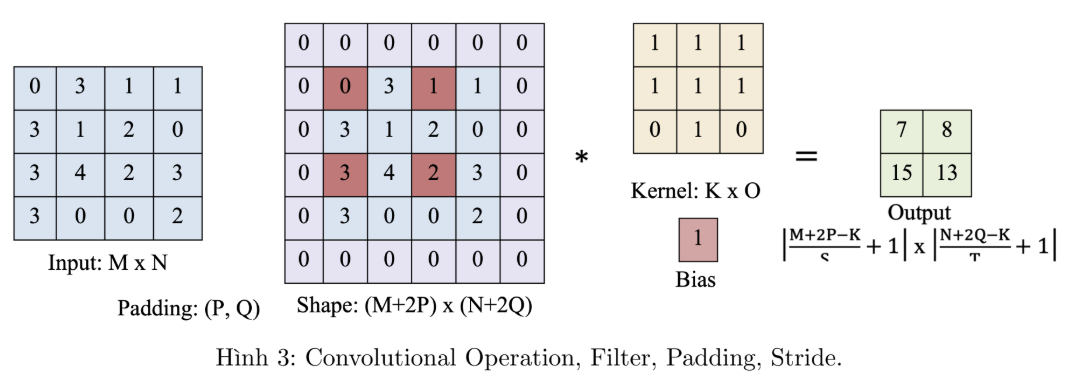

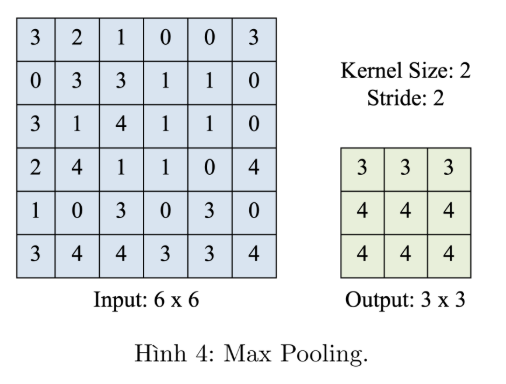

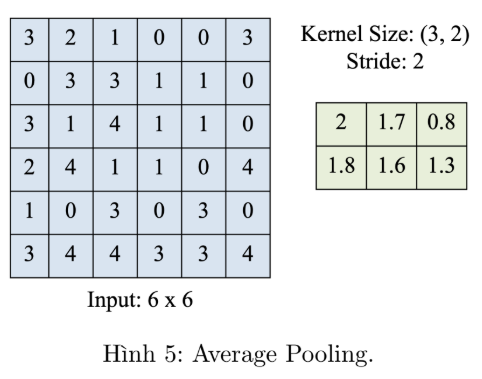

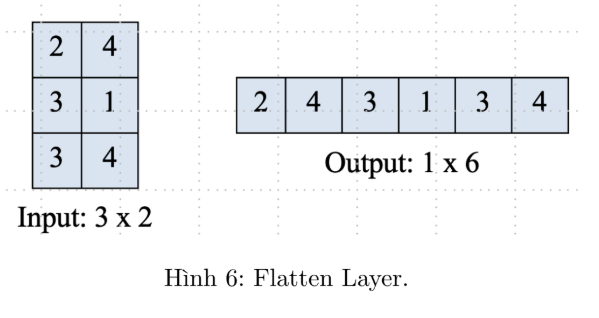

## Import các thư viện cần thiết

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary
from PIL import Image

## Tải về bộ dữ liệu:


In [6]:
data_paths = {
    'train': './cassavaleafdata/train',
    'valid': './cassavaleafdata/validation',
    'test':  './cassavaleafdata/test'}

# load image from path
def loader(path):
  return Image.open(path)

img_size = 150
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    ])

train_data = datasets.ImageFolder(
    root = data_paths['train'],
    loader = loader,
    transform = train_transforms
    )
valid_data = datasets.ImageFolder(
    root = data_paths['valid'],
    transform = train_transforms
    )
test_data = datasets.ImageFolder(
    root = data_paths['test'],
    transform = train_transforms
    )

In [14]:
# Create dataloader
BATCH_SIZE = 256
train_dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

## Tiền xử lý dữ liệu:
- Chia tỉ lệ các tập training: validation = 0.9 : 0.1
- Chuẩn hoá dữ liệu và chuyển sang tensor sử dụng torchvison.transform

## Xây dựng mô hình LeNet:

In [7]:
class LeNetClassifier(nn.Module):
  def __init__(self, num_classes):
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding='same')
      self.avgpool1 = nn.AvgPool2d(kernel_size=2)
      self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
      self.avgpool2 = nn.AvgPool2d(kernel_size=2)
      self.flatten = nn.Flatten()
      self.fc_1 = nn.Linear(16 * 35 * 35, 120)
      self.fc_2 = nn.Linear(120, 84)
      self.fc_3 = nn.Linear(84, num_classes)

  def forward(self, inputs):
      outputs = self.conv1(inputs)
      outputs = self.avgpool1(outputs)
      outputs = F.relu(outputs)
      outputs = self.conv2(outputs)
      outputs = self.avgpool2(outputs)
      outputs = F.relu(outputs)
      outputs = self.flatten(outputs)
      outputs = self.fc_1(outputs)
      outputs = self.fc_2(outputs)
      outputs = self.fc_3(outputs)

      return outputs

## Huấn luyện mô hình:

In [8]:
# Training function
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      predictions = model(inputs)

      # compute loss
      loss = criterion(predictions, labels)
      losses.append(loss.item())

      # backward
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
      optimizer.step()
      total_acc += (predictions.argmax(1) == labels).sum().item()
      total_count += labels.size(0)
      if idx % log_interval == 0 and idx > 0:
        elapsed = time.time() - start_time
        print(
            "| epoch {:3d} | {:5d}/{:5d} batches "
            "| accuracy {:8.3f}".format(
                epoch, idx, len(train_dataloader), total_acc / total_count))
        total_acc, total_count = 0, 0
        start_time = time.time()
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc , epoch_loss

## Đánh giá mô hình:
Ta gọi hàm *evaluate()* để đánh giá performance của model trên hai tập val và test như sau:

In [9]:
# Evaluation function
def evaluate(model, criterion, valid_dataloader):
  model.eval()
  total_acc, total_count = 0, 0
  losses = []

  with torch.no_grad():
    for idx, (inputs, labels) in enumerate(valid_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = model(inputs)

      loss = criterion(predictions, labels)
      losses.append(loss.item())

      total_acc += (predictions.argmax(1) == labels).sum().item()
      total_count += labels.size(0)

  epoch_acc = total_acc / total_count
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss

In [15]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [],[]
eval_accs, eval_losses = [],[]
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
  epoch_start_time = time.time()
  # Training
  train_acc, train_loss= train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  # Evaluation
  eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader)
  eval_accs.append(eval_acc)
  eval_losses.append(eval_loss)

  # Save best model
  if eval_loss < best_loss_eval:
    torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    # Print loss , acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time : {:5.2f}s | Train Accuracy {:8.3f} | Train Loss{:8.3f} | Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(epoch, time.time() - epoch_start_time,
                                                                train_acc, train_loss, eval_acc, eval_loss))
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))
    lenet_model.eval()

-----------------------------------------------------------
| End of epoch   1 | Time : 43.90s | Train Accuracy    0.465 | Train Loss   1.363 | Valid Accuracy    0.473 | Valid Loss    1.418 
-----------------------------------------------------------


<ipython-input-15-07a9161eb477>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))


-----------------------------------------------------------
| End of epoch   2 | Time : 42.47s | Train Accuracy    0.480 | Train Loss   1.315 | Valid Accuracy    0.482 | Valid Loss    1.443 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time : 42.29s | Train Accuracy    0.504 | Train Loss   1.282 | Valid Accuracy    0.516 | Valid Loss    1.396 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time : 42.62s | Train Accuracy    0.522 | Train Loss   1.236 | Valid Accuracy    0.540 | Valid Loss    1.362 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   5 | Time : 42.31s | Train Accuracy    0.532 | Train Loss   1.218 | Valid Accuracy    0.551 | Valid Loss    1.356 
--------------------------------------------------------

# Đánh giá mô hình trên tập test

In [20]:
test_transforms = transforms.Compose([
    transforms.ToTensor()
])
test_data.transform = test_transforms
test_dataloader = data.DataLoader(
    test_data,
    batch_size = BATCH_SIZE)
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader)
test_acc, test_loss

RuntimeError: stack expects each tensor to be equal size, but got [3, 500, 500] at entry 0 and [3, 666, 500] at entry 2